In [1]:
!pip install faker pandas pyarrow geopandas shap --quiet



In [2]:
import os
import random
import math
import numpy as np
import pandas as pd
from faker import Faker
from datetime import datetime, timedelta
import shap

fake = Faker()




In [3]:
N_CUSTOMERS = 5000
N_MERCHANTS = 1200
N_DEVICES = 8000
N_TRANSACTIONS = 60000

OUT_DIR = "/content"



In [4]:
def pick_time(start_dt, days=90):
    offset = random.random() * days * 24 * 3600
    return start_dt + timedelta(seconds=offset)

def add_minutes(dt, mins):
    return dt + timedelta(minutes=mins)

def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    dphi = math.radians(lat2 - lat1)
    dl = math.radians(lon2 - lon1)
    a = math.sin(dphi/2)**2 + math.cos(phi1)*math.cos(phi2)*math.sin(dl/2)**2
    return 2 * R * math.atan2(math.sqrt(a), math.sqrt(1 - a))



In [5]:
customers = []
for i in range(N_CUSTOMERS):
    cust_id = f"C{i:06d}"
    age = int(np.clip(np.random.normal(38, 12), 18, 90))
    income_k = int(np.clip(np.random.lognormal(mean=10, sigma=0.7) / 1000, 20, 300))
    signup = fake.date_between(start_date='-3y', end_date='-30d')
    home_lat = float(fake.latitude())
    home_lon = float(fake.longitude())
    customers.append((cust_id, age, income_k, str(signup), home_lat, home_lon))

customers_df = pd.DataFrame(customers,
                            columns=["customer_id", "age", "income_k", "signup_date", "home_lat", "home_lon"])
print("customers:", customers_df.shape)



customers: (5000, 6)


In [6]:
merchant_categories = ["grocery", "electronics", "travel", "dining", "gas", "utilities", "fashion", "pharmacy"]

merchants = []
for i in range(N_MERCHANTS):
    mid = f"M{i:05d}"
    category = random.choice(merchant_categories)
    base_risk = np.clip(np.random.beta(1,20) * 0.2, 0.0, 0.25)
    if random.random() < 0.02:
        base_risk += np.random.uniform(0.1, 0.4)
    mlat = float(fake.latitude())
    mlon = float(fake.longitude())
    merchants.append((mid, category, base_risk, mlat, mlon))

merchants_df = pd.DataFrame(merchants,
                            columns=["merchant_id", "category", "merchant_base_risk", "m_lat", "m_lon"])

merchants_df["risk_score"] = np.random.uniform(10, 90, size=len(merchants_df))
print("merchants:", merchants_df.shape)



merchants: (1200, 6)


In [7]:
devices = []
for i in range(N_DEVICES):
    dev = f"D{i:05d}"
    owner = np.random.choice(customers_df['customer_id'])
    devices.append((dev, owner))

devices_df = pd.DataFrame(devices, columns=["device_id", "owner_customer_id"])
devices_df["device_type"] = np.random.choice(["mobile", "desktop", "tablet"], size=len(devices_df))
devices_df["risk_score"] = np.random.uniform(5, 80, size=len(devices_df))

print("devices:", devices_df.shape)


devices: (8000, 4)


In [8]:
start_dt = datetime.now() - timedelta(days=90)
transactions = []

for _ in range(N_TRANSACTIONS):
    cust = customers_df.sample(1).iloc[0]
    merchant = merchants_df.sample(1).iloc[0]
    device = devices_df.sample(1).iloc[0]

    ts = pick_time(start_dt)
    amount = max(1.0, float(np.round(np.random.exponential(scale=60.0), 2)))

    fraud_probability = (
        amount / 200 +
        (merchant["risk_score"] / 100) +
        (device["risk_score"] / 100)
    )

    is_fraud = 1 if np.random.random() < fraud_probability else 0

    transactions.append([
        cust["customer_id"], merchant["merchant_id"], device["device_id"],
        ts, amount, merchant["category"], device["device_type"],
        merchant["risk_score"], device["risk_score"], is_fraud
    ])

tx = pd.DataFrame(transactions, columns=[
    "customer_id", "merchant_id", "device_id", "timestamp", "amount",
    "merchant_category", "device_type", "merchant_risk", "device_risk", "is_fraud"
])

print("transactions:", tx.shape)
print("Fraud rate:", tx['is_fraud'].mean())


transactions: (60000, 10)
Fraud rate: 0.9212166666666667


In [9]:
tx.to_parquet(os.path.join(OUT_DIR, "transactions.parquet"), index=False)
tx.to_csv(os.path.join(OUT_DIR, "transactions.csv"), index=False)
print("Saved to:", OUT_DIR)


Saved to: /content


In [10]:
df = tx.copy()
df["timestamp"] = pd.to_datetime(df["timestamp"])
df["hour"] = df["timestamp"].dt.hour
df["dayofweek"] = df["timestamp"].dt.dayofweek

df = df.drop(columns=["timestamp", "customer_id", "merchant_id", "device_id"])
df = pd.get_dummies(df, columns=["merchant_category", "device_type"], drop_first=True)
df.head()



,amount,merchant_risk,device_risk,is_fraud,hour,dayofweek,merchant_category_electronics,merchant_category_fashion,merchant_category_gas,merchant_category_grocery,merchant_category_pharmacy,merchant_category_travel,merchant_category_utilities,device_type_mobile,device_type_tablet
0,54.95,18.224743,59.011270,1,6,0,True,False,False,False,False,False,False,False,False
1,376.94,15.172497,18.701349,1,8,4,False,True,False,False,False,False,False,False,False
2,149.16,45.289580,45.554450,1,2,1,False,False,False,False,False,True,False,False,True
3,28.81,14.416094,69.946314,1,2,1,False,True,False,False,False,False,False,False,True
4,149.10,44.219900,74.969630,1,20,1,False,False,False,False,False,False,False,False,False


In [11]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["is_fraud"])
y = df["is_fraud"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [12]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators=200,
    max_depth=12,
    class_weight="balanced",
    random_state=42
)

model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=12, n_estimators=200,
                       random_state=42)

In [13]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))



              precision    recall  f1-score   support

           0       0.36      0.80      0.50       945
           1       0.98      0.88      0.93     11055

    accuracy                           0.87     12000
   macro avg       0.67      0.84      0.71     12000
weighted avg       0.93      0.87      0.89     12000

Confusion Matrix:
[[ 755  190]
 [1316 9739]]


SHAP shape: (500, 14, 2)
Sampled X shape: (500, 14)


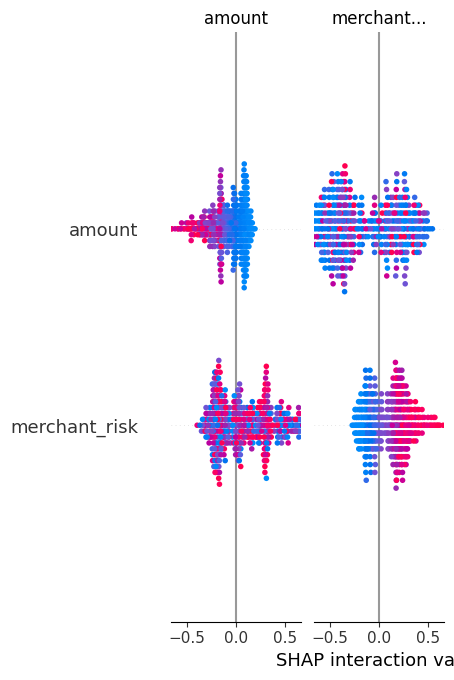

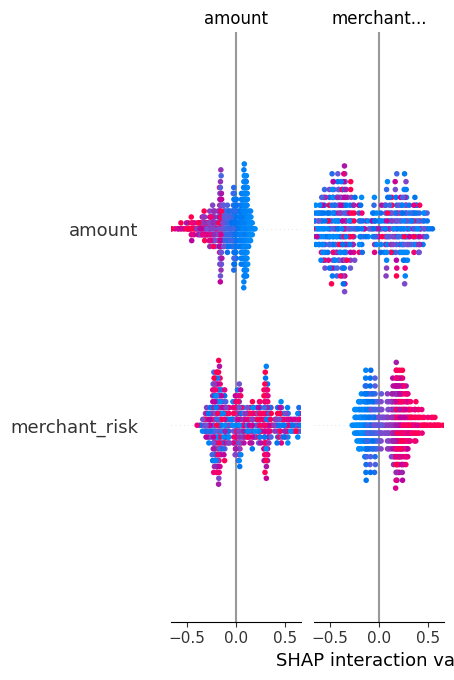

In [14]:
import shap
import numpy as np

# ---- FAST APPROXIMATE TREE SHAP ----
explainer = shap.TreeExplainer(model, feature_perturbation="tree_path_dependent")

# SAMPLE ONLY 500 POINTS to reduce time
X_test_sampled = shap.sample(X_test, 500, random_state=42)

shap_values = explainer.shap_values(X_test_sampled, approximate=True)

# Use positive class if list
if isinstance(shap_values, list):
    shap_values_pos = shap_values[1]
    base_value = explainer.expected_value[1]
else:
    shap_values_pos = shap_values
    base_value = explainer.expected_value

print("SHAP shape:", shap_values_pos.shape)
print("Sampled X shape:", X_test_sampled.shape)

# Summary
shap.summary_plot(shap_values_pos, X_test_sampled)

# Bar plot
shap.summary_plot(shap_values_pos, X_test_sampled, plot_type="bar")



<Figure size 640x480 with 0 Axes>

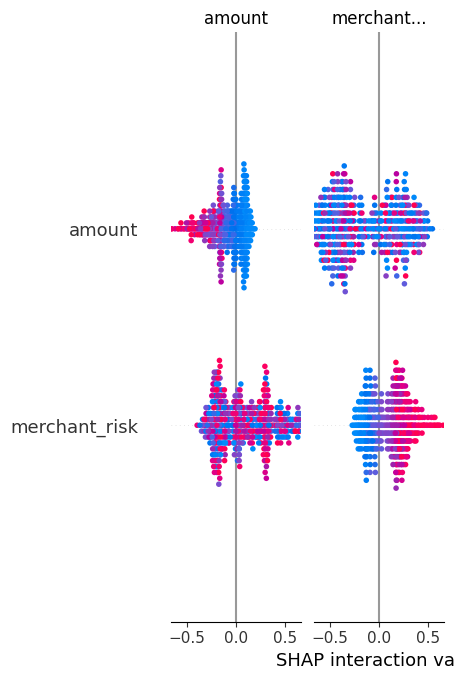

<Figure size 640x480 with 0 Axes>

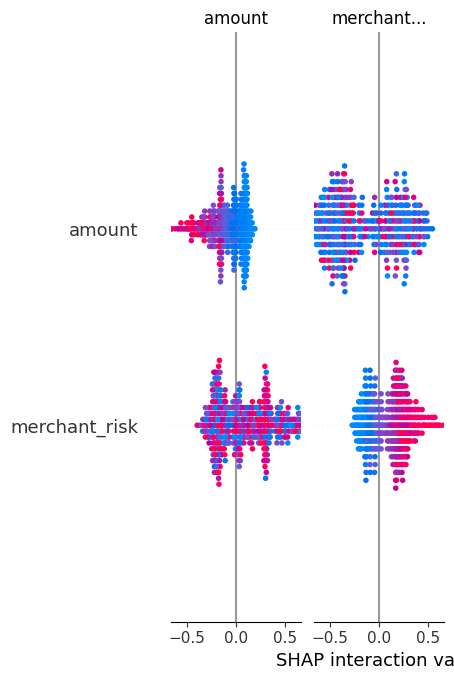

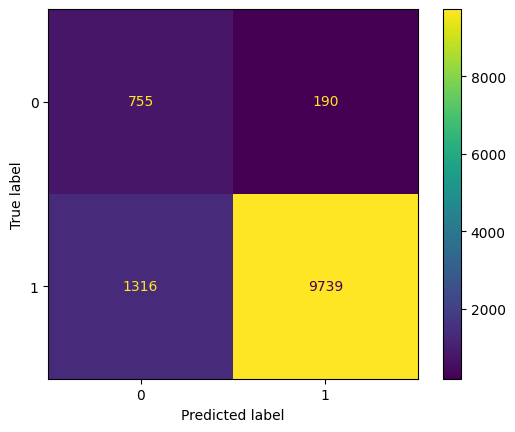

In [15]:
import matplotlib.pyplot as plt

# Save SHAP summary plot
plt.figure()
shap.summary_plot(shap_values_pos, X_test_sampled, show=False)
plt.savefig("shap_summary.png", bbox_inches="tight")

# Bar plot (SAVING)
plt.figure()
shap.summary_plot(shap_values_pos, X_test_sampled, plot_type="bar", show=False)
plt.savefig("shap_bar.png", bbox_inches="tight")

# Confusion matrix (SAVING)
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.savefig("confusion_matrix.png", bbox_inches="tight")


